In [8]:
# 利用rnn进行序列预测

import torch 
from torch import nn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
 
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
torch.manual_seed(1)

# 超参数
TIME_STEP = 10
INPUT_SIZE = 1
LR = 0.02

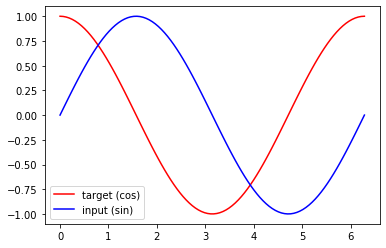

In [10]:
# show data
steps = np.linspace(0,np.pi * 2,100,dtype=np.float32)
x_np = np.sin(steps)
y_np = np.cos(steps)

plt.plot(steps,y_np,'r-',label='target (cos)')
plt.plot(steps,x_np,'b-',label='input (sin)')
plt.legend(loc='best')
plt.show()

In [11]:
class My_RNN(nn.Module):
    def __init__(self):
        super(My_RNN,self).__init__()
        
        self.rnn = nn.RNN(
            input_size = INPUT_SIZE,
            hidden_size = 32,
            num_layers = 1,
            batch_first = True
        )
        
        self.out = nn.Linear(32,1)
        
    def forward(self,x,h_state):
        # x (batch,time_step,input_size)
        # h_state (n_layers,batch,hidden_size)
        # r_out (batch,time_step,hidden_size)
        r_out,h_state = self.rnn(x,h_state)
        
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:,time_step,:]))
        
        # time_step维度合并
        # (batch_size,time_steps)
        return torch.stack(outs,dim=1),h_state

In [12]:
rnn = My_RNN()
print(rnn)

My_RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


In [22]:
# 训练过程
optimizer = torch.optim.Adam(rnn.parameters(),lr=LR)
loss_func = nn.MSELoss()

h_state = None

       
target_list = []
prediction_list = []

for step in range(100):
    start,end = step * np.pi,(step + 1) * np.pi
    
    # sin 预测 cos
    steps = np.linspace(start,end,10,dtype=np.float32)
    
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    
    x = torch.from_numpy(x_np[np.newaxis,:,np.newaxis])
    y = torch.from_numpy(y_np[np.newaxis,:,np.newaxis])
    
    prediction ,h_state = rnn(x,h_state)
    h_state = h_state.data
    
    loss = loss_func(prediction,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    target_list.append(y_np.flatten())
    prediction_list.append(prediction.data.numpy().flatten())


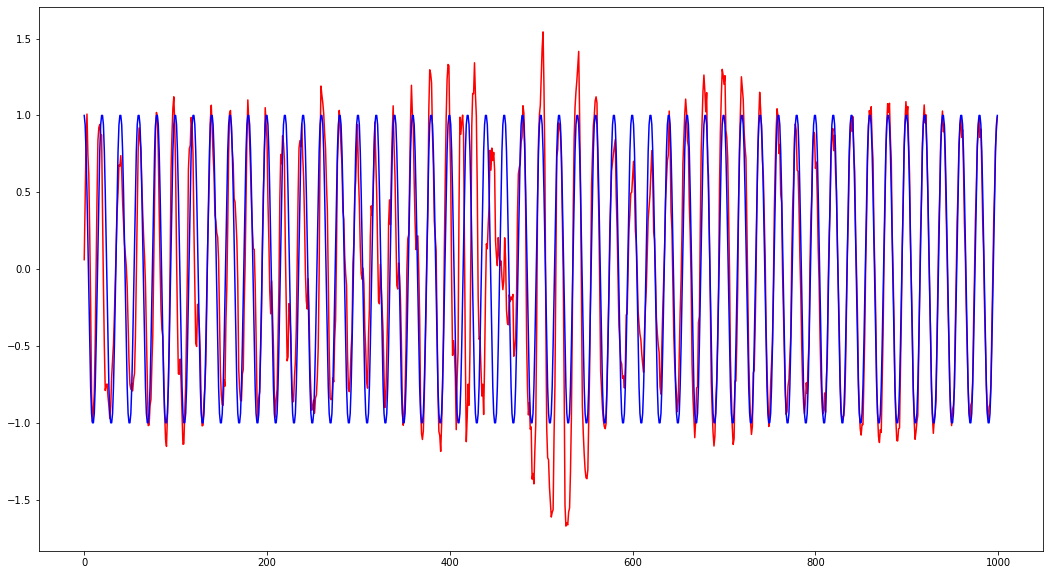

In [23]:
# plot 
prediction_array = np.concatenate(prediction_list,axis=0)
target_array = np.concatenate(target_list,axis=0)

plt.figure(1, figsize=(18, 10))
plt.plot(prediction_array, 'r-')
plt.plot(target_array, 'b-')
plt.show()